In [279]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

sb.set_theme("notebook", "darkgrid")

%matplotlib widget

![alt text](ex22-a.png)

![alt text](ex22-eq50.png)

In [280]:
## Use broadcasting
def Greens_broadcast(energy, h, h_s, V, eta=1e-4, tol=1e-6, max_iter=30, **kwargs):
    """
    Compute the Green's function for a semi-infinite chain using numpy broadcasting.

    This function calculates the bulk and surface Green's functions for a system with 
    a semi-infinite chain, using iterative convergence. Broadcasting is utilized for 
    efficient matrix operations.

    Parameters
    ----------
    energy : ndarray of shape `(K,)`
        Array of energy values at which the Green's function is evaluated.
    h : ndarray of shape `(N, N)`
        On-site matrix for the bulk region of the semi-infinite chain.
    h_s : ndarray of shape `(N, N)`
        On-site matrix for the surface region (initial site of the chain).
    V : ndarray of shape `(N, N)`
        Hopping matrix that defines the coupling between adjacent sites.
    eta : float, optional
        Small imaginary component added to the energy for numerical stability, by default 1e-4.
    tol : float, optional
        Tolerance for convergence in the iterative calculation, by default 1e-6.
    max_iter : int, optional
        Maximum number of iterations allowed for convergence, by default 30.

    Returns
    -------
    G_bulk : ndarray of shape `(K, N, N)`
        Array representing the bulk Green's function at each energy point.
    G_surf : ndarray of shape `(K, N, N)`
        Array representing the surface Green's function at each energy point.

    Notes
    -----
    - Convergence is achieved when the change in the self-energy terms between iterations 
      is below the specified tolerance (`tol`).
    - The imaginary component (`eta`) ensures numerical stability but should be chosen small 
      enough to avoid affecting the results significantly.
    """
    
    # Get dimensions of input
    K = len(energy)
    N, _ = V.shape
    n_dim = len(V.shape)
    
    # Define alpha_0, beta_0
    alpha = V.transpose().copy()[None, ...]
    beta = V.copy()[None, ...]
    
    # Define epsilon_bulk_0, epsilon_surface_0
    E_bulk = h.copy()[None, ...]
    E_surf = h_s.copy()[None, ...]
    
    # Define perturbated energy of size (K, N, N)
    z = (energy + 1.j*eta)[:, *(None,)*n_dim] * np.identity(N)
    
    # Iterate parameters until convergence or max_iter reached
    for _iteration in range(max_iter):
        
        # Iterate bulk and surface greens energy
        G_bulk = np.linalg.inv(z - E_bulk)    
            
        # Iterate alpha and beta
        alpha_new = alpha @ G_bulk @ alpha
        beta_new =   beta @ G_bulk @ beta
        
        # Compute Left and Right self energies
        L_energy =  beta @ G_bulk @ alpha
        R_energy = alpha @ G_bulk @ beta
        
        # Bulk_self_energy = R_energy + L_energy
        
        # Iterate bulk and surface energy
        E_bulk_new = E_bulk + R_energy + L_energy
        E_surf_new = E_surf + R_energy
        
        # Check for convergence
        if np.max(np.abs(alpha_new)) < tol:
            # break if true
            break
        
        # Iterate by redefining parameters
        alpha = alpha_new.copy()
        beta =  beta_new.copy()
        E_bulk = E_bulk_new.copy()
        E_surf = E_surf_new.copy()
    # # Just checking to see if it is changed
    G_surf = np.linalg.inv(z - E_surf)
    if kwargs.get("get_Eb", False):
        return G_bulk, G_surf, E_surf_new
    else:
        return G_bulk, G_surf

In [281]:
# Vpp = 1

# on_site = Vpp * (np.diag(np.ones(3), -1) + np.diag(np.ones(3), 1))

# hopping = Vpp * np.array([[0, 0, 0, 0],
#                           [1, 0, 0, 0],
#                           [0, 0, 0, 1],
#                           [0, 0, 0, 0]])
# # on_site = Vpp * np.array([[0]])
# # hopping = Vpp * np.array([[1]])

# Energy = np.linspace(-2, 2, num=1001)
# G_bulk, G_surf, Sigma_b = Greens_broadcast(Energy, h=on_site, h_s=on_site, V=hopping, get_Eb=True, eta=1e-2)



# # G_bulk, G_surf = Iterate_greens(Energy=Energy, h=on_site, h_s=on_site, V=hopping, eta=1e-2)

# # Plotting
# fig, axes = plt.subplots(4, 2, figsize=(6,6), sharex=True, sharey=True )
# colors= ["r", "b", "k", "g"]
# for i in range(4):
#     # Plots diagonal of each matrix for each energy
#     axes[i,0].plot(Energy, -1/np.pi*np.imag(G_bulk[:, i, i]),  label=f"Atom {i+1}", color=colors[i])
#     axes[i,1].plot(Energy, -1/np.pi*np.imag(G_surf[:, i, i]), label=f"Atom {i+1}", color=colors[i])

# for ax in axes[:,0].flatten():
#     ax.set_ylabel(r"$ -\dfrac{1}{\pi}\ \mathrm{Im}(G)$")
#     ax.legend(loc=(0.42,0.5))
# axes[0,0].set_title("Bulk atoms")
# axes[0,1].set_title("Surface atoms")
# fig.tight_layout()

In [521]:
def k_vec(E, beta, eps):
    arg = (eps - E)/(2*beta)
    print(f"min(arg) = {arg.min()}")
    print(f"max(arg) = {arg.max()}")
    return np.arccos(arg)

def Infinite_chain(energy, hopping, on_site, beta=1, eps=0, eta=1e-3, eps_prime=10):
    n_dim = len(hopping.shape)
    K = len(energy)
    N = hopping.shape[-1]
    z = (energy + 1.j*eta)[:,  *(None,)*n_dim] * np.identity(N)
    
    *(G_bulk, G_surf), E_surf = Greens_broadcast(energy, h=on_site, h_s=on_site, V=hopping, eta=eta, get_Eb=True, eps=eps)
    
    # E_surf is the `epsilon_s = h + Sigma_R` from exercise 21.
    BETA =  beta*hopping # make a (N,N) identity matrix with 
    ENERGY_CHAIN = E_surf - eps
    ENERGY_CENTER = z - eps_prime
    ZEROS = np.zeros((N,N))
    
    # Initilize an empty array
    MATRIX = np.empty((K, 3*N, 3*N), dtype=np.complex128)
    
    
    # Construct matrix
    ##
    ##            | ENERGY_CHAIN,      BETA     ,    ZEROS      |
    ## MATRIX  =  |     BETA    ,  ENERGY_CENTER,     BETA      |
    ##            |    ZEROS    ,      BETA     ,  ENERGY_CHAIN |
    ##
    
    # Define element MATRIX[-1, -1] 
    MATRIX[:, :N, :N] = ENERGY_CHAIN
    
    # Define MATRIX[-1, 0]
    MATRIX[:, :N, N:2*N] = BETA
    
    # Define MATRIX[-1, 1]
    MATRIX[:, :N, 2*N:3*N] = ZEROS
    
    # Define MATRIX[0, -1]
    MATRIX[:, N:2*N, :N] = BETA
    
    # Define MATRIX[0, 0]
    MATRIX[:, N:2*N, N:2*N] = ENERGY_CENTER
    
    # Define MATRIX[0, 1]
    MATRIX[:, N:2*N, 2*N:3*N] = BETA
    
    # Define MATRIX[1, -1]
    MATRIX[:, 2*N:3*N, :N] = ZEROS
    
    # Define MATRIX[1, 0]
    MATRIX[:, 2*N:3*N, N:2*N] = BETA
    
    # Define MATRIX[1, 1]
    MATRIX[:, 2*N:3*N, 2*N:3*N] = ENERGY_CHAIN
    
    G = np.linalg.inv(MATRIX)
    return G
        
def transmission(Energy, hopping, on_site, beta=1, eps=0, eta=1e-3, eps_prime=1):
    
    N = hopping.shape[-1]
    
    G = Infinite_chain(energy=Energy, hopping=hopping, on_site=on_site, beta=beta, eps=eps, eta=eta, eps_prime=eps_prime)
    
    # get element G[-1, 1] from the infinite chain
    G_m1_p1 = G[:, :N, 2*N:3*N]
    
    ks = k_vec(Energy, beta, eps)
    
    # Take the norm along the second to last and last axis (the matrices corresponding to each energy)
    G_norm = np.linalg.norm(G_m1_p1, axis=(-2,-1))
    
    # print(f"{G_norm.shape = }")
    # print(f"{G_norm.min(), G_norm.max() = }")
    # print(f"{4 *G_norm.max()**2= }")
    # print(f"{np.arg() = }")
    return 4 * G_norm**2 * (beta*np.sin(ks))**2

    

min(arg) = -1.0
max(arg) = 1.0


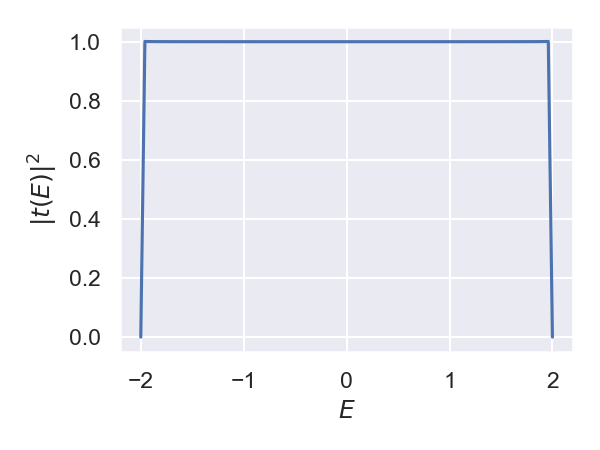

In [522]:
Vpp = 1

# on_site = Vpp * (np.diag(np.ones(3), -1) + np.diag(np.ones(3), 1))

# hopping = Vpp * np.array([[0, 0, 0, 0],
#                           [1, 0, 0, 0],
#                           [0, 0, 0, 1],
#                           [0, 0, 0, 0]])
on_site = Vpp * np.array([[0]])
hopping = Vpp * np.array([[1]])


# Parameters
EPS = 0
EPS_PRIME = 0
BETA = 1

# Range for plotting
Energy = np.linspace(-2, 2, num=101)

t2 = transmission(Energy, hopping, on_site, beta=BETA, eps=EPS, eta=1e-4, eps_prime=EPS_PRIME)

fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=150)
ax.plot(Energy, t2)
# ks = k_vec(Energy, BETA, EPS)
ax.set(xlabel="$E$",
       ylabel="$|t(E)|^2$",
       ylim=(-0.05, 1.05)
       # xlim=(-1.9, 1.9),
       )
fig.tight_layout()